#### Imports

In [ ]:
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn import preprocessing

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_fscore_support as score

import json

import spacy
import nltk
from nltk.corpus import stopwords

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Part A: Thread Subreddit Classification (and Prediction) ##

## Question 1

###Data import and setup

In [ ]:
# A .json file ...
# ... is a file that stores simple data structures (dataframes like a table) in JavaScript Object Notation (JSON) format.
# It is primarily used for transmitting data between a web application and a server.

subreddit_train = "coursework_subreddit_train.json"
subreddit_test = "coursework_subreddit_test.json"

# The gsutil cp command ...
# ... allows you to copy data between your local file system and the cloud
# The gs:// scheme ...
# ... is used for identifying resources stored in Google Cloud Storage.

!gsutil cp gs://textasdata/coursework/coursework_subreddit_train.json $subreddit_train 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

Copying gs://textasdata/coursework/coursework_subreddit_train.json...
\ [1 files][ 10.1 MiB/ 10.1 MiB]                                                
Operation completed over 1 objects/10.1 MiB.                                     
Copying gs://textasdata/coursework/coursework_subreddit_test.json...
- [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [ ]:
# Traininging data

train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
print(list(train_threads.columns.values))
print("--------------------")
print(train_threads.head())
print(train_threads.size)

['is_self_post', 'posts', 'subreddit', 'title', 'url']
--------------------
   is_self_post  ...                                                url
0           1.0  ...  https://www.reddit.com/r/relationships/comment...
1           1.0  ...  https://www.reddit.com/r/summonerschool/commen...
2           1.0  ...  https://www.reddit.com/r/AskReddit/comments/4d...
3           1.0  ...  https://www.reddit.com/r/trees/comments/1h300m...
4           1.0  ...  https://www.reddit.com/r/buildapc/comments/jhb...

[5 rows x 5 columns]
7280


In [ ]:
train_threads.head(5)

,is_self_post,posts,subreddit,title,url
0,1.0,[{'body': 'I think everyone has that one frien...,relationships,How do I [23F] communicate with my self-center...,https://www.reddit.com/r/relationships/comment...
1,1.0,[{'body': 'I not 100% sure this is the right p...,summonerschool,What Cherry switch do you recommend for League...,https://www.reddit.com/r/summonerschool/commen...
2,1.0,"[{'body': '', 'author': 'Leisure321', 'url': '...",askreddit,Where do memes go when they die?,https://www.reddit.com/r/AskReddit/comments/4d...
3,1.0,"[{'body': 'It's called 'forgetting things'.', ...",trees,Some weird long term affects??,https://www.reddit.com/r/trees/comments/1h300m...
4,1.0,[{'body': 'How would I do this? I am looking t...,buildapc,Simple question: If I install Windows to a sta...,https://www.reddit.com/r/buildapc/comments/jhb...


**Note:** .<br>
On reddit, you find different threads (discussions).<br>
Each thread consists of many posts.<br>
Each thread has a title.<br>
Each thread is classified according to a subreddit (like a topic).<br>
All this is visible in the dataframe.<br>




In [ ]:
#Now we can see that the field posts contains many different sub-fields:

train_threads['posts'].iloc[0]

[{'annotations': [{'annotator': '343090f214e68ce7f8a0c4111d6022ec',
    'link_to_post': 't3_2x19a2',
    'main_type': 'answer'},
   {'annotator': 'd0bf500c45ae7c1c08eb65ef0a4e48f9',
    'link_to_post': 't3_2x19a2',
    'main_type': 'answer'},
   {'annotator': 'e9e4b3ab355135fa954badcc06bfccc6',
    'link_to_post': 't3_2x19a2',
    'main_type': 'answer'}],
  'author': 'Pouritdownmythroat',
  'body': 'I think everyone has that one friend who loves to hear themselves talk. If it\'s worth it to you to keep Hannah is your life, try a different approach.\n\nIf you need to talk about something important that requires her full attention, make some serious eye contact and say something to the effect of "Hannah, I truly value your opinion and need your help. I need to speak with you about something near dear to me. Can I have your full attention and advise about this?" She will hopefully understand the gravity of what you are asking. \n\nIf not, it may be time to part way amicably before things 

In [ ]:
# Test data:

test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
print(list(test_threads.columns.values))    # dataframe (table) headings
print("--------------------")
print(test_threads.head())                  # returns the first n (per default 5) rows 
print(test_threads.size)                    # number of posts

['is_self_post', 'posts', 'subreddit', 'title', 'url']
--------------------
   is_self_post  ...                                                url
0           1.0  ...  https://www.reddit.com/r/starcraft/comments/mq...
1           1.0  ...  https://www.reddit.com/r/whowouldwin/comments/...
2           1.0  ...  https://www.reddit.com/r/AskReddit/comments/27...
3           1.0  ...  https://www.reddit.com/r/AskReddit/comments/x9...
4           1.0  ...  https://www.reddit.com/r/tipofmytongue/comment...

[5 rows x 5 columns]
1825


In [ ]:
subreddit_counts = train_threads['subreddit'].value_counts()  # grouping, counting and sorting the threads by unique subreddits ...
print(subreddit_counts)                                       # ... 

print(subreddit_counts.describe())                            # provding statistics about the subreddits

#convert subreddit_counts to a list 
top_subbreddits = subreddit_counts.nlargest(20)               
top_subbreddits_list = top_subbreddits.index.tolist()
print(top_subbreddits)

askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
pcmasterrace             62
gaming                   62
electronic_cigarette     59
relationships            48
tipofmytongue            43
hearthstone              38
jailbreak                38
atheism                  37
summonerschool           37
reddit.com               34
whowouldwin              33
movies                   33
personalfinance          32
starcraft                28
Name: subreddit, dtype: int64
count     20.000000
mean      72.800000
std       73.368285
min       28.000000
25%       36.250000
50%       45.500000
75%       63.750000
max      334.000000
Name: subreddit, dtype: float64
askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
pcmasterrace             62
gaming                

In [ ]:
labels_train_threads = train_threads['subreddit']
labels_test_threads = test_threads['subreddit']

# What we thus have here is 1456 data points (threads) and labels (subreddits) for training
# What we thus have here is 365 data points (threads) and labels (subreddits) for training

### Putting the threads data into pandas Data Frames

Lets put our data in pandas dataframes:

In [ ]:
# THIS FUNCTION BREAKS DOWN EVERYTHING DOWN TO THREADS
def create_dataframe_of_threads(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
      # if (i > 2): break
      title=""
      author=""
      body=""
      thread = json.loads(line)
      
      # Here we are concatenating the data of our posts into single long strings ...
      # ... in order to get a single representative string at thread level
      for post in thread['posts']:
        author = " " + post.get('author',"")
        body = " " + post.get('body',"")
        majority_link = " " + post.get('majority_link',"")
        majority_type = " " + post.get('majority_type',"")
        in_reply_to = "" + post.get('in_reply_to', "")
      
      # Now we have our thread details to send back
      posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], author, body, majority_link, 
                        majority_type, in_reply_to ))
      
  # Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'discourse_type', 'in_reply_to']
  
  return pd.DataFrame(posts_tmp, columns=labels)

In [ ]:
data_train_threads = create_dataframe_of_threads(subreddit_train)            #this is x_train and y_train entangled still

print("We have %d threads in our training dataset"  % len(data_train_threads))
print(data_train_threads.shape)
print(labels_train_threads.shape)

We have 1456 threads in our training dataset
(1456, 9)
(1456,)


In [ ]:
data_test_threads = create_dataframe_of_threads(subreddit_test)              #this is x_test and y_test entangled still

print("We have %d threads in our testing dataset"  % len(data_test_threads))
print(data_test_threads.shape)
print(labels_test_threads.shape)

We have 365 threads in our testing dataset
(365, 9)
(365,)


Now we have our instances with labels.  Now, we need to create a text representation. Before that though, we are going to split the training data into training and validation data as is custom with any machine learning situation.

### Training and Validation Set split

We will now split the **training data** set between training and **validation data** in order to perform training later whilst also tuning the parameters and hyperparameters. The test data will be used later then for predictions and then evaluated against the labels of the test data set for accuracy.<br><br>
We shuffle the data randomly to avoid potential ordering bias. Note that because we are all using different random splits of the data every time we run the notebook the results will differ (very) slightly due to differences in the random splits.

In [ ]:
# shuffle the data randomly to avoid possible bias.
random_data_train = data_train_threads.sample(frac=1)

tmp_train = data_train_threads
# Split the train data into a train/validation split that's 80% train, 20% developemnt 
validation_split = int(len(random_data_train) * 0.8)
data_train_threads = tmp_train.iloc[:validation_split,:]
data_val_threads = tmp_train.iloc[validation_split:,:]

In [ ]:
# Lets check if the data split correctly:
print(tmp_train.shape)
print(data_train_threads.shape)
print(data_val_threads.shape)
print(data_train_threads[0:5])

(1456, 9)
(1164, 9)
(292, 9)
        subreddit  ... in_reply_to
0   relationships  ...  t1_covzfrs
1  summonerschool  ...   t3_2w8jon
2       askreddit  ...   t3_4dr951
3           trees  ...  t1_caqbzo7
4        buildapc  ...    t3_jhbqc

[5 rows x 9 columns]


### Data Preprocessing

We will start by processing the threads with spaCy to tokenize and normalize the text.

spaCy is more accurate in that it does lemmatization as compared to NLTK's porter stemmer with its rules.

In [ ]:
# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
!python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list
nltk.download('stopwords')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [ ]:
tokenize_normalize("this is a test. we are hopeful.")

['this', 'is', 'a', 'test', 'we', 'are', 'hopeful']

In [ ]:
#Lets do a quick demonstration test

one_hot_vectorizer__test = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
one_hot_vectorizer__test.fit(['this', 'is', 'a', 'test', 'we', 'are', 'hopeful'])                 # creates the dictionary (to store the vocabulary) - this is essentially the training
print(one_hot_vectorizer__test.transform(['this', 'is', 'a', 'test', 'we', 'are', 'hopeful']))    # one-hot encoding 

# Thus, we created a vectorizer then ...
# fit the training data to it
# then performed encoding on it
# This creates input features for our classification on all subsets of our collection.

# below we have a dictionary with seven terms. They are all one-hot encoded
# If the vocabulary had many more words and we only show those that are one-hot encoded - that would be a sparse representation

# Note: In Deep Learning, when dealing with classifying more than one class (e.g. dogs, cats and horses) we were dealing with:
# Multilabel Single Variable

  (0, 5)	1
  (1, 3)	1
  (2, 0)	1
  (3, 4)	1
  (4, 6)	1
  (5, 1)	1
  (6, 2)	1


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Data and Label: <br>
For Section A here the, the subreddits will function as the labels. Thus, we will try to classify our threads according to the community it belongs to.

### One-hot encoding

#### Vectorize

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# #TRAINING DATA

# # Pass in the tokenizer function as the tokenizer to the vectorizer.
# # Create a one-hot encoding vectorizer.
# # each vectoriser gets its own dictionary
# one_hot_vectorizer__training_title = CountVectorizer(tokenizer=tokenize_normalize, binary=True)    
# one_hot_vectorizer__training_body = CountVectorizer(tokenizer=tokenize_normalize, binary=True)     
# one_hot_vectorizer__training_author = CountVectorizer(tokenizer=tokenize_normalize, binary=True) 

# # creates the dictionary (to store the vocabulary)
# features_train_title_onehot = one_hot_vectorizer__training_title.fit_transform(data_train['title'])         # x_train_title            
# features_train_body_onehot = one_hot_vectorizer__training_body.fit_transform(data_train['body'])            # x_train_body
# features_train_author_onehot = one_hot_vectorizer__training_author.fit_transform(data_train['author'])      # x_train_author

# train_labels = data_train_threads['subreddit']                                                                  # y_train 

# print(features_train_title_onehot.shape)
# print(features_train_body_onehot.shape)
# print(train_labels.shape)

# #VALIDATION DATA

# # Pass in the tokenizer function as the tokenizer to the vectorizer.
# # Create a one-hot encoding vectorizer.
# # each vectoriser gets its own dictionary
# one_hot_vectorizer__validation_title = CountVectorizer(tokenizer=tokenize_normalize, binary=True)    
# one_hot_vectorizer__validation_body = CountVectorizer(tokenizer=tokenize_normalize, binary=True)     
# one_hot_vectorizer__validation_author = CountVectorizer(tokenizer=tokenize_normalize, binary=True) 

# # creates the dictionary (to store the vocabulary)
# features_val_title_onehot = one_hot_vectorizer__validation_title.fit_transform(data_validation['title'])      # x_validation_title            
# features_val_body_onehot = one_hot_vectorizer__validation_body.fit_transform(data_validation['body'])         # x_validation_body
# features_val_author_onehot = one_hot_vectorizer__validation_author.fit_transform(data_validation['author'])   # x_validation_author

# val_labels = data_val_threads['subreddit']                                                                      # y_validation

# print(features_val_title_onehot.shape)
# print(features_val_body_onehot.shape)
# print(val_labels.shape)

# #TESTING DATA

# # Pass in the tokenizer function as the tokenizer to the vectorizer.
# # Create a one-hot encoding vectorizer.
# # each vectoriser gets its own dictionary
# one_hot_vectorizer__testing_title = CountVectorizer(tokenizer=tokenize_normalize, binary=True)    
# one_hot_vectorizer__testing_body = CountVectorizer(tokenizer=tokenize_normalize, binary=True)     
# one_hot_vectorizer__testing_author = CountVectorizer(tokenizer=tokenize_normalize, binary=True) 

# # creates the dictionary (to store the vocabulary)
# features_test_title_onehot = one_hot_vectorizer__testing_title.fit_transform(data_test['title'])      # x_test_title            
# features_test_body_onehot = one_hot_vectorizer__testing_body.fit_transform(data_test['body'])         # x_test_body
# features_test_author_onehot = one_hot_vectorizer__testing_author.fit_transform(data_test['author'])   # x_test_author

# test_labels = data_test_threads['subreddit']                                                                    # y_test

# print(features_test_title_onehot.shape)
# print(features_test_body_onehot.shape)
# print(test_labels.shape)

# # The data of testing_features_title is in the form:
# #
# #              Dictionary items
# #          term1 term2 term3 term4 ...
# # thread1    0     0     0     1
# # thread2    1     1     0     0
# # thread3    0     0     1     0
# # thread4    0     0     0     0
# # ...

Each feature could be vectorised independently and then combined. However, since the same tokenization and normalization has been decided to be applied on each of the features identified (text, body and author) it was decided to use a pipeline and feature union to do it easily. (This also avoids having to work with hstack). <br>

*SKLearn has multiple ways of combining features. We'll look at both of them in this lab. The first (and easiest) ways is to use a FeatureUnion as part of Pipeline. There's a nice post on how to be a Kaggle Pro using FeatureUnion and Piplines.
In particular, a pipeline allows you to control the different parameters and experiment with different values (e.g. regularization, vocabulary sizes, etc..).
In particular, a common pattern is to use multiple fields of a Pandas dataset. Recall that there is also a "summary" field in our data. Let's use it as a separate set of features. Unfortunately, Pandas does not play nice with SKLearn pipelines. We need to add a special column selector transformer that runs first before our vectorizer in the pipeline.*

In [ ]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
## define pipeline with one hot encoder

# Use FeatureUnion to combine the features from text and summary
onehot_threads_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize, binary=True)), 
              ])),
        ])
        )
    ])

# Thus, we created a vectorizer then ...

In [ ]:
# ... fit it to the training data
# then performed encoding on it
# This creates input features for our classification on all subsets of our collection:

features_train_onehot = onehot_threads_pipeline.fit_transform(data_train_threads)                       # x_train
features_test_onehot = onehot_threads_pipeline.transform(data_test_threads)                             # x_test

# We will then (again)... fit these features with the labels to a classifier, thus training a model

# Remember we already have this:
train_labels = data_train_threads['subreddit']                                                          # y_train
test_labels = data_test_threads['subreddit']                                                            # y_test

 **The point is we eventually do .fit twice:**<br>
 **1. to fit the vectoriser model to the training data i.e. to a data frame (or particular field of a data frame).
    This is done using our pipeline (or done directly).
    The fit is to create a vocabulary, whereas the transform does the actual encoding and creates the vector**<br>
    The output is features here. We use the pipeline to create the features<br>
 **2. to fit (train) the classifier model **<br>
 The input is features here.

Now lets train some classifiers using the training:

It is important in practice to always have a baseline - you need to know that you are better than randomly guessing the class. Sklearn provides instances of **DummyClassifier** for this purpose. 

In [ ]:
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1,average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(y_true=true_labels, y_pred=predictions))#,labels=true_labels)) # Note the order here is true, predicted, odd.

#### Dummy Classifier (with strategy = most frequent)

In [ ]:
dummy_prior = DummyClassifier(strategy='most_frequent')
dummy_prior.fit(features_train_onehot, train_labels)
print(dummy_prior.score(features_test_onehot, test_labels))
print("----")
evaluation_summary("Dummy Majority", dummy_prior.predict(features_test_onehot), test_labels)

0.23013698630136986
----
Evaluation for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       r

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Dummy Classifier (with strategy = stratified)

In [ ]:
dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(features_train_onehot, train_labels)
print(dummy_prior.score(features_test_onehot, test_labels))
print("----")
evaluation_summary("Dummy Prior", dummy_prior.predict(features_test_onehot), test_labels)

0.09041095890410959
----
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.088 P=0.035 R=0.035 F1=0.035
                      precision    recall  f1-score   support

           askreddit      0.179     0.176     0.178        85
             atheism      0.000     0.000     0.000         6
            buildapc      0.054     0.059     0.056        34
electronic_cigarette      0.000     0.000     0.000        15
   explainlikeimfive      0.071     0.067     0.069        15
              gaming      0.118     0.133     0.125        15
         hearthstone      0.000     0.000     0.000         6
           jailbreak      0.000     0.000     0.000         5
     leagueoflegends      0.229     0.190     0.208        58
              movies      0.000     0.000     0.000         6
        pcmasterrace      0.043     0.083     0.057        12
     personalfinance      0.000     0.000     0.000        10
          reddit.com      0.000     0.000     0.000         9
       relatio

#### Logistic Regression

Below we have a logistic regression classifier (model):<br>

We train it using the .fit statement and feeding it the features (x_train) and labels (y_train).<br>
The output of the training is assigned to the model.

In [ ]:
# Specify a solver=saga, a variation of stochastic gradient decent

lr = LogisticRegression(solver='saga')
lr_onehot_model = lr.fit(features_train_onehot, train_labels)
print(lr_onehot_model.score(features_test_onehot, test_labels))
print("----")
evaluation_summary("LR onehot", lr_onehot_model.predict(features_test_onehot), test_labels) 

0.4575342465753425
----
Evaluation for: LR onehot
Classifier 'LR onehot' has Acc=0.458 P=0.288 R=0.338 F1=0.297
                      precision    recall  f1-score   support

           askreddit      0.821     0.543     0.654       127
             atheism      0.083     0.200     0.118         5
            buildapc      0.676     0.595     0.633        42
electronic_cigarette      0.222     0.222     0.222         9
   explainlikeimfive      0.500     0.467     0.483        15
              gaming      0.059     0.091     0.071        11
         hearthstone      0.200     0.500     0.286         6
           jailbreak      0.091     0.250     0.133         4
     leagueoflegends      0.625     0.429     0.508        70
              movies      0.000     0.000     0.000         4
        pcmasterrace      0.130     0.176     0.150        17
     personalfinance      0.300     0.600     0.400         5
          reddit.com      0.000     0.000     0.000         2
       relationship

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### SVC (SVM with RBF kernel)

In [ ]:
svc = SVC(gamma='auto',kernel='rbf')
svc_onehot_model = svc.fit(features_train_onehot,train_labels)
print(svc_onehot_model.score(features_test_onehot, test_labels))
print("----")
evaluation_summary("SVC One-Hot Encoding", svc_onehot_model.predict(features_test_onehot), test_labels)

0.23013698630136986
----
Evaluation for: SVC One-Hot Encoding
Classifier 'SVC One-Hot Encoding' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Naive Bayes Classifier

In [ ]:
## one-hot and Naive Bayes
## A "bernoulli distribution" is for binary values, whether a value is present or not. 
## We use the BernoulliNB for features with a one-hot encoding.

nb = BernoulliNB()
nb_onehot_model = nb.fit(features_train_onehot, train_labels)
print(nb_onehot_model.score(features_test_onehot, test_labels))
print("----")
evaluation_summary("NB One-Hot Encoding", nb_onehot_model.predict(features_test_onehot), test_labels)           

0.2410958904109589
----
Evaluation for: NB One-Hot Encoding
Classifier 'NB One-Hot Encoding' has Acc=0.241 P=0.055 R=0.045 F1=0.029
                      precision    recall  f1-score   support

           askreddit      1.000     0.238     0.384       353
             atheism      0.000     0.000     0.000         0
            buildapc      0.108     0.667     0.186         6
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         1
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         5
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tfidf

#### Vectorize

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# #TRAINING DATA

# # Pass in the tokenizer function as the tokenizer to the vectorizer.
# # Create a one-hot encoding vectorizer.
# # each vectoriser gets its own dictionary
# tfidf_vectorizer__training_title = CountVectorizer(tokenizer=tokenize_normalize, binary=True)    
# tfidf_vectorizer__training_body = CountVectorizer(tokenizer=tokenize_normalize, binary=True)     
# tfidf_vectorizer__training_author = CountVectorizer(tokenizer=tokenize_normalize, binary=True) 

# # creates the dictionary (to store the vocabulary)
# train_features_title = tfidf_vectorizer__training_title.fit_transform(data_train['title'])         # x_train_title            
# train_features_body = tfidf_vectorizer__training_body.fit_transform(data_train['body'])            # x_train_body
# train_features_author = tfidf_vectorizer__training_author.fit_transform(data_train['author'])      # x_train_author

# train_labels = data_train['subreddit']                                                             # y_train 

# print(train_features_title.shape)
# print(train_features_body.shape)
# print(train_labels.shape)

# #VALIDATION DATA

# # Pass in the tokenizer function as the tokenizer to the vectorizer.
# # Create a one-hot encoding vectorizer.
# # each vectoriser gets its own dictionary
# tfidf_vectorizer__validation_title = CountVectorizer(tokenizer=tokenize_normalize, binary=True)    
# tfidf_vectorizer__validation_body = CountVectorizer(tokenizer=tokenize_normalize, binary=True)     
# tfidf_vectorizer__validation_author = CountVectorizer(tokenizer=tokenize_normalize, binary=True) 

# # creates the dictionary (to store the vocabulary)
# validation_features_title = tfidf_vectorizer__validation_title.fit_transform(data_validation['title'])      # x_validation_title            
# validation_features_body = tfidf_vectorizer__validation_body.fit_transform(data_validation['body'])         # x_validation_body
# validation_features_author = tfidf_vectorizer__validation_author.fit_transform(data_validation['author'])   # x_validation_author

# validation_labels = data_validation['subreddit']                                                            # y_validation

# print(validation_features_title.shape)
# print(validation_features_body.shape)
# print(validation_labels.shape)

# #TESTING DATA

# # Pass in the tokenizer function as the tokenizer to the vectorizer.
# # Create a one-hot encoding vectorizer.
# # each vectoriser gets its own dictionary
# tfidf_vectorizer__testing_title = CountVectorizer(tokenizer=tokenize_normalize, binary=True)    
# tfidf_vectorizer__testing_body = CountVectorizer(tokenizer=tokenize_normalize, binary=True)     
# tfidf_vectorizer__testing_author = CountVectorizer(tokenizer=tokenize_normalize, binary=True) 

# # creates the dictionary (to store the vocabulary)
# testing_features_title = tfidf_vectorizer__testing_title.fit_transform(data_test['title'])      # x_test_title            
# testing_features_body = tfidf_vectorizer__testing_body.fit_transform(data_test['body'])         # x_test_body
# testing_features_author = tfidf_vectorizer__testing_author.fit_transform(data_test['author'])   # x_test_author

# testing_labels = data_test['subreddit']                                                         # y_test

# print(testing_features_title.shape)
# print(testing_features_body.shape)
# print(testing_labels.shape)

In [ ]:
## define pipeline with tfidf encoder

# Use FeatureUnion to combine the features from text and summary
tfidf_threads_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
        ])
        )
    ])

In [ ]:
features_train_tfidf = tfidf_threads_pipeline.fit_transform(data_train_threads)                       # x_train
features_test_tfidf = tfidf_threads_pipeline.transform(data_test_threads)                             # x_test

# Note: We use the training data to build a vocabulary (using the fit command) 
#       then create a one-hot vector (using the transform command).
#       However, for the test data we just vectorise it. We do not create a vocabulary.


# Remember we already have this:
train_labels = data_train_threads['subreddit']                                                          # y_train
test_labels = data_test_threads['subreddit'] 

#### Dummy Classifier (with strategy = most frequent)

In [ ]:
dummy_prior = DummyClassifier(strategy='most_frequent')
dummy_prior.fit(features_train_tfidf, train_labels)
print(dummy_prior.score(features_test_tfidf, test_labels))
print("----")
evaluation_summary("Dummy Majority", dummy_prior.predict(features_test_tfidf), test_labels)

0.23013698630136986
----
Evaluation for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       r

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Dummy Classifier (with strategy = stratified)

In [ ]:
dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(features_train_tfidf, train_labels)
print(dummy_prior.score(features_test_tfidf, test_labels))
print("----")
evaluation_summary("Dummy Prior", dummy_prior.predict(features_test_tfidf), test_labels)

0.09863013698630137
----
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.090 P=0.051 R=0.048 F1=0.049
                      precision    recall  f1-score   support

           askreddit      0.238     0.204     0.220        98
             atheism      0.000     0.000     0.000         5
            buildapc      0.027     0.037     0.031        27
electronic_cigarette      0.111     0.077     0.091        13
   explainlikeimfive      0.071     0.040     0.051        25
              gaming      0.000     0.000     0.000        16
         hearthstone      0.133     0.118     0.125        17
           jailbreak      0.182     0.200     0.190        10
     leagueoflegends      0.042     0.042     0.042        48
              movies      0.000     0.000     0.000         3
        pcmasterrace      0.043     0.062     0.051        16
     personalfinance      0.000     0.000     0.000         4
          reddit.com      0.000     0.000     0.000         6
       relatio

#### Logistic Regression

In [ ]:
lr = LogisticRegression(solver='saga')
lr_tfidf_model = lr.fit(features_train_tfidf, train_labels)
print(lr_tfidf_model.score(features_test_tfidf, test_labels))
print("----")
evaluation_summary("LR tfidf", lr_tfidf_model.predict(features_test_tfidf), test_labels) 

0.4520547945205479
----
Evaluation for: LR tfidf
Classifier 'LR tfidf' has Acc=0.452 P=0.213 R=0.330 F1=0.210
                      precision    recall  f1-score   support

           askreddit      0.952     0.426     0.588       188
             atheism      0.000     0.000     0.000         0
            buildapc      0.784     0.630     0.699        46
electronic_cigarette      0.111     1.000     0.200         1
   explainlikeimfive      0.429     0.857     0.571         7
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.792     0.349     0.484       109
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         1
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### SVC (SVM with RBF kernel)

In [ ]:
svc = SVC(gamma='auto',kernel='rbf')
svc_tfidf_model = svc.fit(features_train_tfidf,train_labels)
print(svc_tfidf_model.score(features_test_tfidf, test_labels))
print("----")
evaluation_summary("SVC One-Hot Encoding", svc_tfidf_model.predict(features_test_tfidf), test_labels)

0.23013698630136986
----
Evaluation for: SVC One-Hot Encoding
Classifier 'SVC One-Hot Encoding' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Naive Bayes Classifier

In [ ]:
## one-hot and Naive Bayes

nb = BernoulliNB()
nb_tfidf_model = nb.fit(features_train_tfidf, train_labels)
print(nb_tfidf_model.score(features_test_tfidf, test_labels))
print("----")
evaluation_summary("NB One-Hot Encoding", nb_tfidf_model.predict(features_test_tfidf), test_labels)           

0.2410958904109589
----
Evaluation for: NB One-Hot Encoding
Classifier 'NB One-Hot Encoding' has Acc=0.241 P=0.055 R=0.045 F1=0.029
                      precision    recall  f1-score   support

           askreddit      1.000     0.238     0.384       353
             atheism      0.000     0.000     0.000         0
            buildapc      0.108     0.667     0.186         6
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         1
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         5
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot of best result

It seems as though the best macro F1 performance came from one-hot encoding the data and using logistic regression for the classification.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  
  

def create_plot(text, model, prediction, test_labels):
  precision, reacall, fscore, support = score(prediction,test_labels)

  bars = np.arange(len(model.classes_))
  classes = model.classes_
  width=.4
  fig, ax=plt.subplots(1,1,figsize=(8,6))
  rects1 = ax.bar(bars, fscore, width)

  ax.set_ylabel('F1')
  ax.set_title(text)
  ax.set_xticks(bars+width/3)
  plt.xticks(rotation='vertical')
  ax.set_xticklabels(classes)

  plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


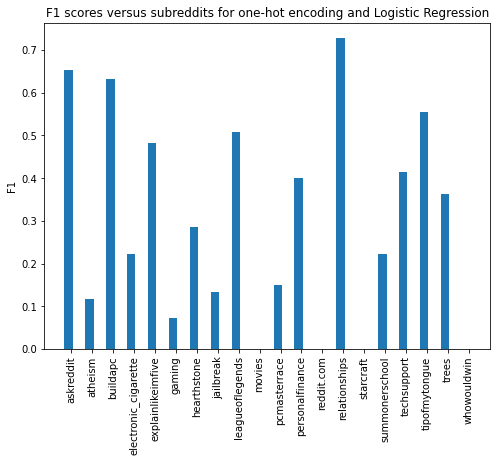

In [ ]:
create_plot('F1 scores versus subreddits for one-hot encoding and Logistic Regression', 
            lr_onehot_model, lr_onehot_model.predict(features_test_onehot), test_labels)

Confusion matrix, without normalization


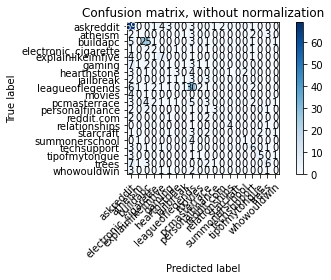

In [ ]:
subreddits=['askreddit','atheism','buildapc','electronic_cigarette','explainlikeimfive', 'gaming',     
            'hearthstone','jailbreak','leagueoflegends','movies','pcmasterrace','personalfinance','reddit.com','relationships','starcraft','summonerschool','techsupport',     
            'tipofmytongue',  'trees', 'whowouldwin' ]
  
plot_confusion_matrix(test_labels, lr_onehot_model.predict(features_test_onehot), subreddits, title='Confusion matrix, without normalization')

Categorical data is best encoded with a one-hot encoding, whilst logistic regression, being a linear model, is particularly suited for dealing with categorical data because it learns a singel weight per feature.

## Question 2

In this task your goal is to improve the **effectiveness of a baseline LogisticRegression with TF-IDF vectorization**.

In [ ]:
# Since we are going to perform logistic regression on one-hot encoded vectors
# we can now build a pipeline specifically tailored for that purpose:

# Use FeatureUnion to combine the features from text and summary
tfidf_lr_threads_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False)), 
              ])),
        ])
        ),
       ('classifier', LogisticRegression())
    ])

### Parameter Tuning

We will now attempt to perform parameter tuning on the vectorizer and the classifier: <br>
According to instructions, address: <br>
- Regularization of the C value of LogisticRegression (typical values might be powers of 10 (from 10^-3 to 10^4), 
- multi_class and 
- solver<br>

Vectorizer parameters include: <br>
- sublinear_tf, 
- ngram_range (from one word up to length 3), and 
- max_features (vocabulary size) for the three fields (None to approximately 50k).

In [ ]:
# This is our parameter dictionary

params = [
   {'classifier__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000)},
   
   {'classifier__multi_class': ('ovr', 'multinomial','auto'),
    'classifier__solver': ('newton-cg', 'lbfgs', 'sag', 'saga')},
   
   {'union__body__tfidf__max_features': (None, 5000, 10000, 50000),
    'union__body__tfidf__ngram_range': ((1, 1),(1, 2), (1, 3)),
    'union__body__tfidf__sublinear_tf': (True, False)},
   
   {'union__title__tfidf__max_features': (None, 5000, 10000, 50000),
    'union__title__tfidf__ngram_range': ((1, 1),(1, 2), (1, 3)),
    'union__title__tfidf__sublinear_tf': (True, False)},
   
   {'union__author__tfidf__max_features': (None, 5000, 10000, 50000),
    'union__author__tfidf__ngram_range': ((1, 1),(1, 2), (1, 3)),
    'union__author__tfidf__sublinear_tf': (True, False)}
 ]

#### Grid Search

In [ ]:
gridsearch_results = []
gridsearch_score = []
  
for param in params:
  grid_search = GridSearchCV(tfidf_lr_threads_pipeline, param_grid=param, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in tfidf_lr_threads_pipeline.steps])
  print("parameters:")
  print(param)
  grid_search.fit(data_train_threads, train_labels)
  gridsearch_score.append(grid_search.best_score_)
  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(param.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
  gridsearch_results.append("%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['union', 'classifier']
parameters:
{'classifier__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000)}
Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   21.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.287
Best parameters set:
	classifier__C: 10000
Performing grid search...
pipeline: ['union', 'classifier']
parameters:
{'classifier__multi_class': ('ovr', 'multinomial', 'auto'), 'classifier__solver': ('newton-cg', 'lbfgs', 'sag', 'saga')}
Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Best score: 0.123
Best parameters set:
	classifier__multi_class: 'multinomial'
	classifier__solver: 'newton-cg'
Performing grid search...
pipeline: ['union', 'classifier']
parameters:
{'union__body__tfidf__max_features': (None, 5000, 10000, 50000), 'union__body__tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)), 'union__body__tfidf__sublinear_tf': (True, False)}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.6min finished


Best score: 0.127
Best parameters set:
	union__body__tfidf__max_features: 10000
	union__body__tfidf__ngram_range: (1, 3)
	union__body__tfidf__sublinear_tf: False
Performing grid search...
pipeline: ['union', 'classifier']
parameters:
{'union__title__tfidf__max_features': (None, 5000, 10000, 50000), 'union__title__tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)), 'union__title__tfidf__sublinear_tf': (True, False)}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.2min finished


Best score: 0.123
Best parameters set:
	union__title__tfidf__max_features: None
	union__title__tfidf__ngram_range: (1, 1)
	union__title__tfidf__sublinear_tf: False
Performing grid search...
pipeline: ['union', 'classifier']
parameters:
{'union__author__tfidf__max_features': (None, 5000, 10000, 50000), 'union__author__tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)), 'union__author__tfidf__sublinear_tf': (True, False)}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   49.7s finished


Best score: 0.123
Best parameters set:
	union__author__tfidf__max_features: None
	union__author__tfidf__ngram_range: (1, 1)
	union__author__tfidf__sublinear_tf: True


#### Results

The Grid Search seemed to reveal the following results as providing the best results for tuning the classifier and vectorizer.

Re-fit and execute after tuning
Results
* 'union__body__tfidf__max_features':5000
* 'union__body__tfidf__ngram_range': (1, 2)
* 'union__body__tfidf__sublinear_tf': False,

* 'union__title__tfidf__max_features': None
* 'union__title__tfidf__ngram_range': (1, 1)}
* 'union__title__tfidf__sublinear_tf': True,

* 'union__author__tfidf__max_features': None
* 'union__author__tfidf__ngram_range': (1, 1)
* 'union__author__tfidf__sublinear_tf': True

* classifier__C: try 10000
* classifier__multi_class: 'auto'
* classifier__solver: 'saga

#### Make optimal tuning changes

Based on the outcome of the Grid Search, a new pipeline was created with the prefered parameters stipulated for the vectorizers and classifiers:

In [ ]:
# Since we are going to perform logistic regression on one-hot encoded vectors
# we can now build a pipeline specifically tailored for that purpose:

# Use FeatureUnion to combine the features from text and summary
tuned_tfidf_lr_threads_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
              ])),              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
        ])
        )
    ])



In [ ]:
tunedfeatures_train_tfidf = tuned_tfidf_lr_threads_pipeline.fit_transform(data_train_threads)                       # x_train
tunedfeatures_test_tfidf = tuned_tfidf_lr_threads_pipeline.transform(data_test_threads)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
tuned_lr_tfidf_model = lr.fit(tunedfeatures_train_tfidf, train_labels)
evaluation_summary("Tuned LR tfidf", tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf), test_labels) 

Evaluation for: Tuned LR tfidf
Classifier 'Tuned LR tfidf' has Acc=0.507 P=0.333 R=0.434 F1=0.344
                      precision    recall  f1-score   support

           askreddit      0.881     0.544     0.673       136
             atheism      0.167     0.333     0.222         6
            buildapc      0.703     0.684     0.693        38
electronic_cigarette      0.222     0.500     0.308         4
   explainlikeimfive      0.500     0.389     0.438        18
              gaming      0.059     0.100     0.074        10
         hearthstone      0.133     0.500     0.211         4
           jailbreak      0.182     0.667     0.286         3
     leagueoflegends      0.688     0.493     0.574        67
              movies      0.000     0.000     0.000         3
        pcmasterrace      0.217     0.294     0.250        17
     personalfinance      0.300     1.000     0.462         3
          reddit.com      0.000     0.000     0.000         2
       relationships      0.833  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


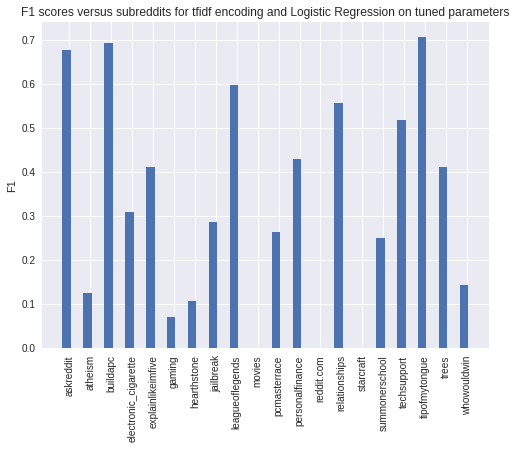

In [ ]:
create_plot('F1 scores versus subreddits for tfidf encoding and Logistic Regression on tuned parameters', 
            tuned_lr_tfidf_model, tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf), test_labels)

Confusion matrix, without normalization


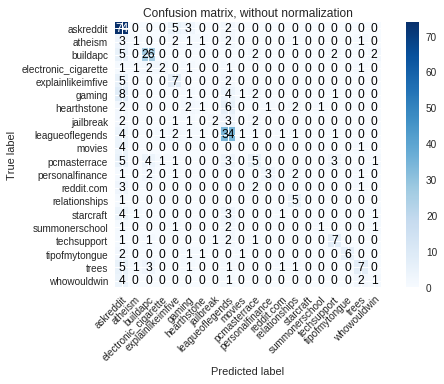

In [ ]:
subreddits=['askreddit','atheism','buildapc','electronic_cigarette','explainlikeimfive', 'gaming',     
            'hearthstone','jailbreak','leagueoflegends','movies','pcmasterrace','personalfinance','reddit.com','relationships','starcraft','summonerschool','techsupport',     
            'tipofmytongue',  'trees', 'whowouldwin' ]
  
plot_confusion_matrix(test_labels, tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf), subreddits, title='Confusion matrix, without normalization')

Just looking at the F1 macro average alone, introducing the parameter tuning improved the metric from 0.187 to 0.336.

### Error Analysis

Manually examine the examples that your algorithm made prediction errors on. See if you spot any systematic trend in what type of examples it is making errors on. You will report on and summarize these findings.

In [ ]:
# print(train_threads[train_threads.subreddit=='leagueoflegends'].iloc[0].title)
# print("--------")
# train_threads[train_threads.subreddit=='leagueoflegends'].iloc[0].posts

predictions_tuned_lr_tfidf = tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf)

print("Prediction:", predictions_tuned_lr_tfidf[1])
print("Ground Truth:", test_labels[1])
print("Body:")
print(data_test_threads.iloc[1].body)

Prediction: askreddit
Ground Truth: whowouldwin
Body:
 Healing factor as in wound healing (including dismemberment and the like) or complete regeneration of life?

If its the latter, than Rai is almost unstoppable, if he can use his powers without worrying about draining his life

If it's the former, then a good boost, but he was practically untouchable to begin with


In this particular example, the model predicted the subreddit to be *askreddit* whereas it was really *whowouldwin*.  According to the confusion matrix, this happened a few times. The likely reasoning behind this is that the classifier is picking up similarly structured conversations where everyone will chip in to try and give their opinion to answer the central question. Ultimately, each case is unique.

### Feature Development

Two features will be added to attempt to address this problem: <br>
The first is **body length.** If you, for example, compare the two subreddits again, askreddit versus whowouldwin, you would expect askreddit to have less posts than whowouldwin, because the former will typically have the thread end when a very good answer is given that no one can really improve or elaborate upon meaningfully. However, in communities like whowouldwin there should be a lot more posts because everyone thinks they are right and there is no definitive way to decided who has the superior answer when the posts are based on opinion of future or hypothetical occurrences. <br>
The second feature that will be added is **stopword** removal for the body. Stop words whould preferably not be removed from the title.

In [ ]:
#We will have to create a new data frame in order to have a body length field:
# THIS FUNCTION BREAKS DOWN EVERYTHING DOWN TO THREADS
def create_new_dataframe_of_threads(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
      # if (i > 2): break
      title=""
      author=""
      body=""
      body_length=0
      thread = json.loads(line)
      
      # Here we are concatenating the data of our posts into single long strings ...
      # ... in order to get a single representative string at thread level     
      for post in thread['posts']:
        author = " " + post.get('author',"")
        body = " " + post.get('body',"")
        body_length = body_length + 1
        majority_link = " " + post.get('majority_link',"")
        majority_type = " " + post.get('majority_type',"")
        in_reply_to = "" + post.get('in_reply_to', "")
      
      # Now we have our thread details to send back
      posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], author, body, str(body_length), majority_link, 
                        majority_type, in_reply_to ))
      
  # Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'body_length', 'majority_link', 
          'discourse_type', 'in_reply_to']
  
  return pd.DataFrame(posts_tmp, columns=labels)

In [ ]:
data_train_threads = create_new_dataframe_of_threads(subreddit_train)
data_test_threads = create_new_dataframe_of_threads(subreddit_test)

train_labels = data_train_threads['subreddit']                                                          # y_train
test_labels = data_test_threads['subreddit']  

In [ ]:
def tokenize_normalize_stop_word_removal(string):
  return [word for word in tokenize_normalize(string) if word not in set(stopwords.words("english"))]

In [ ]:
# Use FeatureUnion to combine the features from text and summary
tuned_ver2_tfidf_lr_threads_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_stop_word_removal, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
              ])),              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
            ('body_length', Pipeline([
              ('selector', ItemSelector(key='body_length')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize)), 
              ])),                
        ])
        )
    ])

In [ ]:
tunedfeatures_v2_train_tfidf = tuned_ver2_tfidf_lr_threads_pipeline.fit_transform(data_train_threads)                       # x_train
tunedfeatures_v2_test_tfidf = tuned_ver2_tfidf_lr_threads_pipeline.transform(data_test_threads)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
tuned_v2_lr_tfidf_model = lr.fit(tunedfeatures_v2_train_tfidf, train_labels)
evaluation_summary("Tuned ver 2 LR tfidf", tuned_v2_lr_tfidf_model.predict(tunedfeatures_v2_test_tfidf), test_labels) 

Evaluation for: Tuned ver 2 LR tfidf
Classifier 'Tuned ver 2 LR tfidf' has Acc=0.518 P=0.350 R=0.445 F1=0.355
                      precision    recall  f1-score   support

           askreddit      0.869     0.566     0.685       129
             atheism      0.250     1.000     0.400         3
            buildapc      0.703     0.650     0.675        40
electronic_cigarette      0.333     0.375     0.353         8
   explainlikeimfive      0.571     0.364     0.444        22
              gaming      0.059     0.100     0.074        10
         hearthstone      0.200     1.000     0.333         3
           jailbreak      0.182     0.500     0.267         4
     leagueoflegends      0.729     0.538     0.619        65
              movies      0.000     0.000     0.000         1
        pcmasterrace      0.087     0.133     0.105        15
     personalfinance      0.400     1.000     0.571         4
          reddit.com      0.000     0.000     0.000         3
       relationships 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


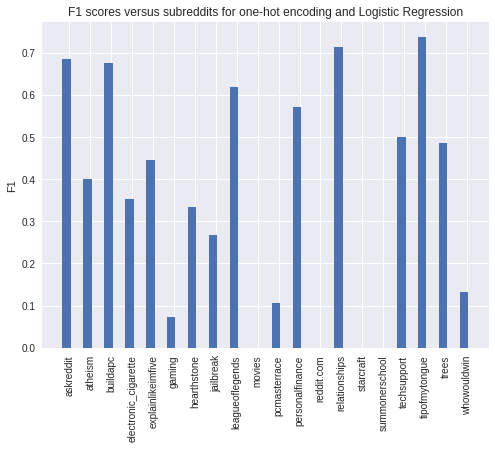

In [ ]:
create_plot('F1 scores versus subreddits for one-hot encoding and Logistic Regression', 
            tuned_v2_lr_tfidf_model, tuned_v2_lr_tfidf_model.predict(tunedfeatures_v2_test_tfidf), test_labels)

Confusion matrix, without normalization


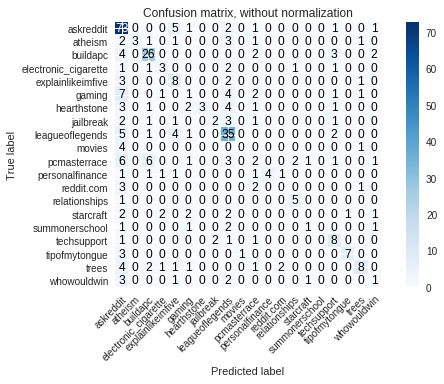

In [ ]:
subreddits=['askreddit','atheism','buildapc','electronic_cigarette','explainlikeimfive', 'gaming',     
            'hearthstone','jailbreak','leagueoflegends','movies','pcmasterrace','personalfinance','reddit.com','relationships','starcraft','summonerschool','techsupport',     
            'tipofmytongue',  'trees', 'whowouldwin' ]
  
plot_confusion_matrix(test_labels, tuned_v2_lr_tfidf_model.predict(tunedfeatures_v2_test_tfidf), subreddits, title='Confusion matrix, without normalization')

Add the two features did indeed bring about an improved, even if not by much. Thus, my hunch was correct. The F1 macro average went from 0.336 to 0.35.

# Part B: Comment Discourse Classification (and Prediction) ##

## Question 3

In [ ]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

Copying gs://textasdata/coursework/coursework_discourse_train.json...
- [1 files][ 60.2 MiB/ 60.2 MiB]                                                
Operation completed over 1 objects/60.2 MiB.                                     
Copying gs://textasdata/coursework/coursework_discourse_test.json...
- [1 files][ 15.1 MiB/ 15.1 MiB]                                                
Operation completed over 1 objects/15.1 MiB.                                     


In [ ]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.

# THIS FUNCTION BREAKS DOWN EVERYTHING DOWN TO POSTS
def create_dataframe_of_posts(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      for post in thread['posts']:
        # NOTE: This could be changed to use additional features from the post or thread.
        # DO NOT change the labels for the test set.
        posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', ""), post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', "") ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to']
  return pd.DataFrame(posts_tmp, columns=labels)

# THIS PUTS THE DATA IN THE FORM:
# 1 title1 body1 author1 subreddit1 
# 2 title1 body2 author2 subreddit1
# 3 title1 body3 author3 subreddit1
# 4 title1 body4 author4 subreddit1
# 5 title1 body5 author5 subreddit1
# ...

In [ ]:
data_train_posts = create_dataframe_of_posts(discourse_train)

print("We have %d posts in our training dataset"  % len(data_train_posts))

We have 88498 posts in our training dataset


In [ ]:
data_test_posts = create_dataframe_of_posts(discourse_test)              #this is x_test and y_test entangled still

print("We have %d posts in our testing dataset"  % len(data_test_posts))

We have 22097 posts in our testing dataset


In [ ]:
# Filter out empty labels
data_train_posts = data_train_posts[data_train_posts['discourse_type'] != ""]
print(data_train_posts.head())
print("Num posts: ", data_train_posts.size)

    subreddit                           title  \
0  worldofpvp  Help me decide my new PvP main   
1  worldofpvp  Help me decide my new PvP main   
2  worldofpvp  Help me decide my new PvP main   
3  worldofpvp  Help me decide my new PvP main   
4  worldofpvp  Help me decide my new PvP main   

                                                 url          id  \
0  https://www.reddit.com/r/worldofpvp/comments/2...   t3_2v0anq   
1  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codb2p9   
2  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codg0we   
3  https://www.reddit.com/r/worldofpvp/comments/2...  t1_coeatsq   
4  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codbyit   

         author                                               body  \
0      TyrickEU  Hi. \nAs a raider previously, i had no problem...   
1          vurt  [deleted]  \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...   
2   OptimusNice  This goes mostly for 3v3 since that seems to b...   
3               

The label for the post we will be predicting is in the discourse_type column.

In [ ]:
# Filter out empty labels
data_test_posts = data_test_posts[data_test_posts['discourse_type'] != ""]
print("Num posts: ", data_test_posts.size)


Num posts:  198120


In [ ]:
train_labels = data_train_posts['discourse_type']
test_labels = data_test_posts['discourse_type']

Examine the distribution over labels on the training data.

In [ ]:
discourse_counts = train_labels.value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(200)
print(top_discourse)
top_discourse = top_discourse.index.tolist()
print(top_discourse)

count       10.000000
mean      7926.700000
std       9664.321866
min       1266.000000
25%       1671.500000
50%       3235.500000
75%      11919.750000
max      31419.000000
Name: discourse_type, dtype: float64
answer              31419
elaboration         14775
question            13610
appreciation         6849
agreement            3868
disagreement         2603
humor                1787
other                1633
announcement         1457
negativereaction     1266
Name: discourse_type, dtype: int64
['answer', 'elaboration', 'question', 'appreciation', 'agreement', 'disagreement', 'humor', 'other', 'announcement', 'negativereaction']


In [ ]:
## define pipeline with tfidf encoder

tuned_tfidf_lr_posts_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[              
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
              ])),              
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),              
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
              ])),
        ])
        )
    ])

In [ ]:
tunedfeatures_train_tfidf = tuned_tfidf_lr_posts_pipeline.fit_transform(data_train_posts)                       # x_train
tunedfeatures_test_tfidf = tuned_tfidf_lr_posts_pipeline.transform(data_test_threads)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
tuned_lr_tfidf_model = lr.fit(tunedfeatures_train_tfidf, train_labels)
evaluation_summary("Tuned LR tfidf", tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf), test_labels) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: Tuned LR tfidf
Classifier 'Tuned LR tfidf' has Acc=0.458 P=0.259 R=0.288 F1=0.268
                  precision    recall  f1-score   support

       agreement      0.230     0.314     0.266       697
    announcement      0.096     0.125     0.108       281
          answer      0.614     0.539     0.574      9045
    appreciation      0.529     0.584     0.555      1557
    disagreement      0.069     0.125     0.089       351
     elaboration      0.258     0.276     0.267      3394
           humor      0.028     0.078     0.042       166
negativereaction      0.075     0.161     0.102       143
           other      0.109     0.175     0.134       234
        question      0.580     0.504     0.540      3944

       micro avg      0.458     0.458     0.458     19812
       macro avg      0.259     0.288     0.268     19812
    weighted avg      0.494     0.458     0.474     19812


Confusion matrix:
 [[ 219   18  358   66   19  152    8    8   11   92]
 [   5   35  1

### Plot of Results

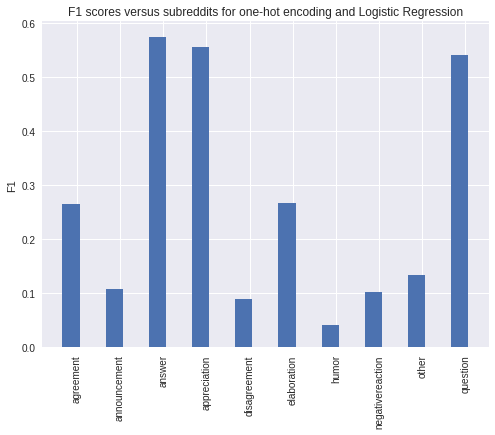

In [ ]:
create_plot('F1 scores versus subreddits for one-hot encoding and Logistic Regression', 
            tuned_lr_tfidf_model, tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf), test_labels)

Confusion matrix, without normalization


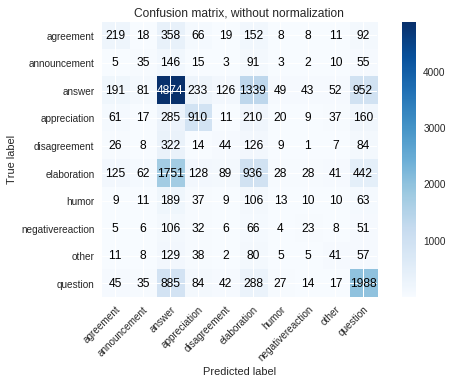

In [ ]:
plot_confusion_matrix(test_labels, tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf), classes=tuned_lr_tfidf_model.classes_, title='Confusion matrix, without normalization')

### Error Analysis

In [ ]:
predictions_tuned_lr_tfidf = tuned_lr_tfidf_model.predict(tunedfeatures_test_tfidf)

print("Prediction:", predictions_tuned_lr_tfidf[1])
print("Ground truth:", test_labels[1])
print("Body:")
print(data_test_posts.iloc[1].body)

Prediction: answer
Ground truth: question
Body:
are you in the USA?  i would say that unless the road says "no stopping unless emergency" or something then you are good to go.  that being said, fully expect a cop to stop and harass you about it.

i moved (from the US) to new zealand and stopped on the side of the desert highway (where you can see Mt Doom from LotR) to take some photos at night, a cop stopped, turned around, and came... and asked if i needed help!  ah, kiwi land =)


In this particular example, a question was confused for an answer.  This might be that the question is merely four words followed by two longer sentences where the person discuss matters concerning that question.

## Question 4

We will now address 6 features to see if they contribute to a better effectiveness. They will be chosen in the order they were presented in the assessed exercise:<br>
- Metadata
- Content+Punctuation
- Structure
- Author
- Thread Features
- Community

First however, we need to create a new dataframe that includes all the new features we need.

In [ ]:
# THIS FUNCTION BREAKS DOWN EVERYTHING DOWN TO POSTS
def create_dataframe_of_posts_withmorefeatures(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      
      # body length feature
      # This is so that all the posts in the thread have this body length number going forward
      body_length = 0
      for post in thread['posts']:
        body_length = body_length + 1

      #for ever single post one by one  
      for post in thread['posts']:
        
        # total comments feature
        total_comments = str(len(thread['posts']))
        
        #self author feature
        same_auth=0
        if(thread['is_self_post']==None):
          thread['is_self_post']=0
        thread['top_author']=thread['posts'][0].get('author',"")
        if(thread['top_author']==post.get('author',"")):
          same_auth=1
        
        sub_self = thread['subreddit'] + " " +  str(thread['is_self_post'])
        
        # some properties here will be from the post, and some data (like 'title') 
        # lie at the thread level.
        posts_tmp.append((thread['subreddit'], thread['title'], post['id'], 
                        post.get('author', ""), str(same_auth), post.get('body', ""), str(body_length),
                        total_comments,   
                        thread['url'], post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', ""),
                        sub_self ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'id', 'author', 'same_auth', 'body', 'body_length', 'total_comments', 'url', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to', 'sub_self']
  return pd.DataFrame(posts_tmp, columns=labels)


In [ ]:
data_train_posts = create_dataframe_of_posts_withmorefeatures(discourse_train)
data_test_posts = create_dataframe_of_posts_withmorefeatures(discourse_test)
# Filter out empty labels
data_train_posts = data_train_posts[data_train_posts['discourse_type'] != ""]
print("Num posts: ", data_train_posts.shape)
# Filter out empty labels
data_test_posts = data_test_posts[data_test_posts['discourse_type'] != ""]
print("Num posts: ", data_test_posts.shape)

Num posts:  (79267, 14)
Num posts:  (19812, 14)


Lets look quickly at the dataframe we constructed:

In [ ]:
data_train_posts.head(20)

,subreddit,title,id,author,same_auth,body,body_length,total_comments,url,majority_link,post_depth,discourse_type,in_reply_to,sub_self
0,worldofpvp,Help me decide my new PvP main,t3_2v0anq,TyrickEU,1,"Hi. \nAs a raider previously, i had no problem...",7,7,https://www.reddit.com/r/worldofpvp/comments/2...,none,0,question,,worldofpvp 1.0
1,worldofpvp,Help me decide my new PvP main,t1_codb2p9,vurt,0,[deleted] \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...,7,7,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,1,answer,t3_2v0anq,worldofpvp 1.0
2,worldofpvp,Help me decide my new PvP main,t1_codg0we,OptimusNice,0,This goes mostly for 3v3 since that seems to b...,7,7,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,1,answer,t3_2v0anq,worldofpvp 1.0
3,worldofpvp,Help me decide my new PvP main,t1_coeatsq,,0,"Rets are in a good position right now, althoug...",7,7,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,1,answer,t3_2v0anq,worldofpvp 1.0
4,worldofpvp,Help me decide my new PvP main,t1_codbyit,Rageinjector,0,Druid are the best pvp healer atm and are grea...,7,7,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,1,answer,t3_2v0anq,worldofpvp 1.0
5,worldofpvp,Help me decide my new PvP main,t1_coef9rv,ElyonZ,0,"Druid any spec is OP right now, even if they g...",7,7,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,1,answer,t3_2v0anq,worldofpvp 1.0
6,worldofpvp,Help me decide my new PvP main,t1_cofuikq,Seripha,0,In general druid is a super nice allround. Fer...,7,7,https://www.reddit.com/r/worldofpvp/comments/2...,t3_2v0anq,1,answer,t3_2v0anq,worldofpvp 1.0
7,anime,Anime so bad it's good?,t3_3zdmxu,PM_ME_UR_SPACEBALLS,1,Just lookin to pass some time with a bad funny...,40,40,https://www.reddit.com/r/anime/comments/3zdmxu...,none,0,question,,anime 1.0
8,anime,Anime so bad it's good?,t1_cylazgc,Soupkitten,0,Cross Ange. That was a crazy ride.,40,40,https://www.reddit.com/r/anime/comments/3zdmxu...,t3_3zdmxu,1,answer,t3_3zdmxu,anime 1.0
9,anime,Anime so bad it's good?,t1_cylbxsl,lt13jimmy,0,Crazy ride indeed. Glad I finished it.,40,40,https://www.reddit.com/r/anime/comments/3zdmxu...,t1_cylazgc,2,agreement,t1_cylazgc,anime 1.0


### Metadata
○ Subreddit (possibly combined with other features) <br>
○ Is a post a link post or a self-post?

In [ ]:
metadata_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      #Metadata 
      ('sub_self', Pipeline([
        ('selector', ItemSelector(key='sub_self')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
   
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with metadata feature
Classifier 'LR Baseline with metadata feature' has Acc=0.471 P=0.276 R=0.313 F1=0.286
                  precision    recall  f1-score   support

       agreement      0.238     0.329     0.276       686
    announcement      0.203     0.167     0.183       444
          answer      0.634     0.545     0.586      9240
    appreciation      0.549     0.616     0.580      1533
    disagreement      0.087     0.165     0.114       340
     elaboration      0.258     0.283     0.270      3304
           humor      0.050     0.142     0.074       162
negativereaction      0.065     0.155     0.092       129
           other      0.101     0.209     0.136       182
        question      0.576     0.520     0.546      3792

       micro avg      0.471     0.471     0.471     19812
       macro avg      0.276     0.313     0.286     19812
    weighted avg      0.508     0.471     0.486     19812


Confusion matrix:
 [[ 226   12  360   62   18  1

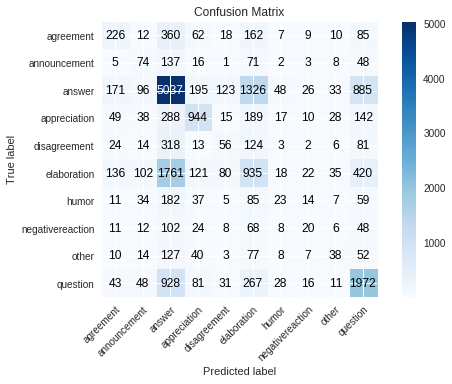

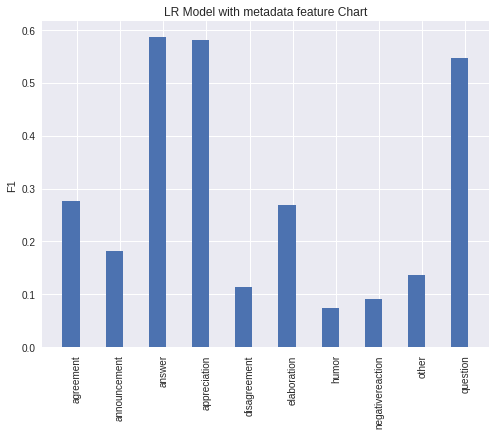

In [ ]:
metadata_train_tfidf = metadata_pipeline.fit_transform(data_train_posts)                       # x_train
metadata_test_tfidf = metadata_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
metadata_lr_tfidf_model = lr.fit(metadata_train_tfidf, train_labels)

evaluation_summary("LR Baseline with metadata feature", metadata_lr_tfidf_model.predict(metadata_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, metadata_lr_tfidf_model.predict(metadata_test_tfidf), metadata_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with metadata feature Chart', metadata_lr_tfidf_model, metadata_lr_tfidf_model.predict(metadata_test_tfidf), test_labels)

### Content+Punctuation
○ A tokenizer that includes punctuation / emoticons as tokens instead of removing them

In [ ]:
# This is the tokenizer that removes punctuation
def normalize_keeppunct(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit or token.is_punct )):
      normalized_tokens.append(normalized)
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize_keeppunct(string):
  return normalize_keeppunct(spacy_tokenize(string))

In [ ]:
contpunct_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_keeppunct, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with content+punctuation feature
Classifier 'LR Baseline with content+punctuation feature' has Acc=0.493 P=0.284 R=0.321 F1=0.296
                  precision    recall  f1-score   support

       agreement      0.241     0.327     0.277       701
    announcement      0.129     0.172     0.147       273
          answer      0.634     0.553     0.591      9094
    appreciation      0.563     0.616     0.589      1573
    disagreement      0.062     0.117     0.081       343
     elaboration      0.294     0.302     0.298      3540
           humor      0.072     0.185     0.104       178
negativereaction      0.075     0.153     0.101       150
           other      0.104     0.164     0.127       238
        question      0.670     0.617     0.642      3722

       micro avg      0.493     0.493     0.493     19812
       macro avg      0.284     0.321     0.296     19812
    weighted avg      0.528     0.493     0.508     19812


Confusion matrix:
 [[ 229 

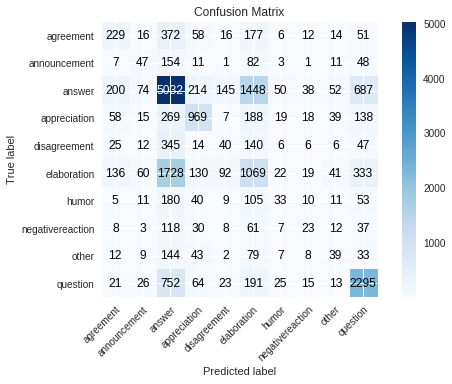

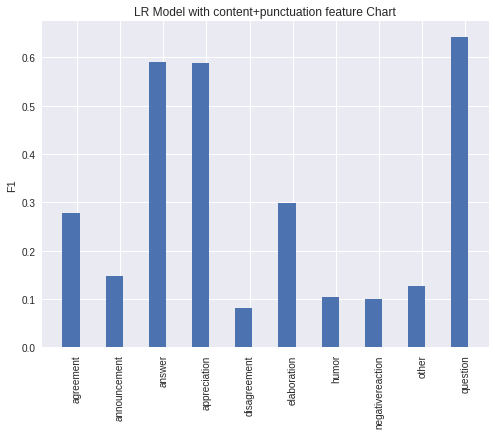

In [ ]:
contpunct_train_tfidf = contpunct_pipeline.fit_transform(data_train_posts)                       # x_train
contpunct_test_tfidf = contpunct_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
contpunct_lr_tfidf_model = lr.fit(contpunct_train_tfidf, train_labels)

evaluation_summary("LR Baseline with content+punctuation feature", contpunct_lr_tfidf_model.predict(contpunct_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, contpunct_lr_tfidf_model.predict(contpunct_test_tfidf), contpunct_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with content+punctuation feature Chart', contpunct_lr_tfidf_model, contpunct_lr_tfidf_model.predict(contpunct_test_tfidf), test_labels)

### Structure 
○ Body Length

In [ ]:
structure_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_keeppunct, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
        
      #Structure  
      ('body_length', Pipeline([
        ('selector', ItemSelector(key='body_length')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
    
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with content+punctuation feature
Classifier 'LR Baseline with content+punctuation feature' has Acc=0.494 P=0.289 R=0.329 F1=0.302
                  precision    recall  f1-score   support

       agreement      0.252     0.332     0.287       722
    announcement      0.156     0.245     0.191       233
          answer      0.626     0.555     0.588      8960
    appreciation      0.562     0.611     0.586      1582
    disagreement      0.075     0.127     0.094       377
     elaboration      0.312     0.296     0.304      3833
           humor      0.061     0.162     0.089       173
negativereaction      0.081     0.164     0.109       152
           other      0.093     0.148     0.114       236
        question      0.667     0.644     0.655      3544

       micro avg      0.494     0.494     0.494     19812
       macro avg      0.289     0.329     0.302     19812
    weighted avg      0.522     0.494     0.506     19812


Confusion matrix:
 [[ 240 

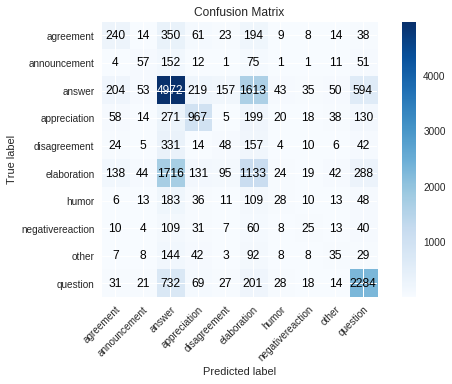

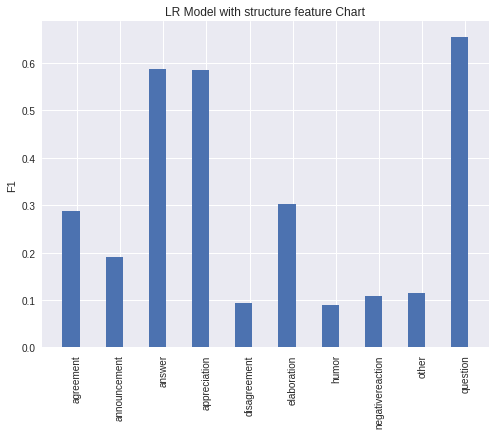

In [ ]:
structure_train_tfidf = structure_pipeline.fit_transform(data_train_posts)                       # x_train
structure_test_tfidf = structure_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
structure_lr_tfidf_model = lr.fit(structure_train_tfidf, train_labels)

evaluation_summary("LR Baseline with structure feature", structure_lr_tfidf_model.predict(structure_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, structure_lr_tfidf_model.predict(structure_test_tfidf), structure_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with structure feature Chart', structure_lr_tfidf_model, structure_lr_tfidf_model.predict(structure_test_tfidf), test_labels)

### Author
○ A binary feature for whether the current author is also the author of the initial post

In [ ]:
sameauthor_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_keeppunct, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
        
      #Author  
      ('same_auth', Pipeline([
        ('selector', ItemSelector(key='same_auth')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
    
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with content+punctuation feature
Classifier 'LR Baseline with content+punctuation feature' has Acc=0.520 P=0.315 R=0.348 F1=0.325
                  precision    recall  f1-score   support

       agreement      0.256     0.349     0.295       697
    announcement      0.334     0.334     0.334       365
          answer      0.671     0.578     0.621      9217
    appreciation      0.566     0.620     0.592      1569
    disagreement      0.070     0.133     0.092       339
     elaboration      0.284     0.303     0.293      3404
           humor      0.061     0.160     0.089       175
negativereaction      0.085     0.166     0.112       157
           other      0.098     0.161     0.122       230
        question      0.721     0.675     0.697      3659

       micro avg      0.520     0.520     0.520     19812
       macro avg      0.315     0.348     0.325     19812
    weighted avg      0.557     0.520     0.536     19812


Confusion matrix:
 [[ 243 

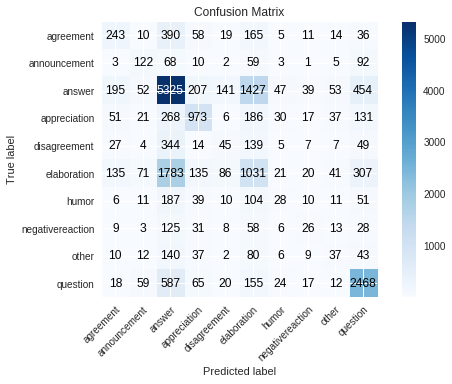

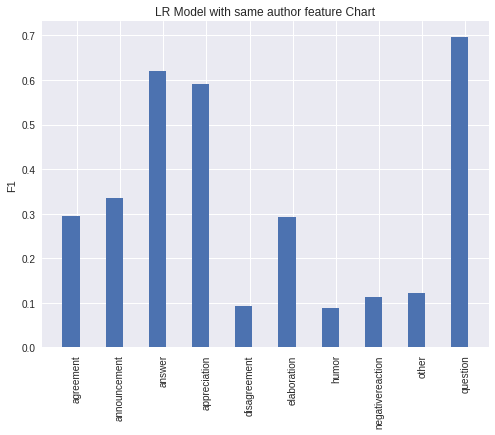

In [ ]:
sameauthor_train_tfidf = sameauthor_pipeline.fit_transform(data_train_posts)                       # x_train
sameauthor_test_tfidf = sameauthor_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
sameauthor_lr_tfidf_model = lr.fit(sameauthor_train_tfidf, train_labels)

evaluation_summary("LR Baseline with same author feature", sameauthor_lr_tfidf_model.predict(sameauthor_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, sameauthor_lr_tfidf_model.predict(sameauthor_test_tfidf), sameauthor_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with same author feature Chart', sameauthor_lr_tfidf_model, sameauthor_lr_tfidf_model.predict(sameauthor_test_tfidf), test_labels)

### Thread Features
○ The total number of comments in the discussion

In [ ]:
totalcomments_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_keeppunct, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
        
      #Total Comments  
      ('total_comments', Pipeline([
        ('selector', ItemSelector(key='total_comments')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
    
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with content+punctuation feature
Classifier 'LR Baseline with content+punctuation feature' has Acc=0.494 P=0.289 R=0.328 F1=0.301
                  precision    recall  f1-score   support

       agreement      0.250     0.329     0.284       723
    announcement      0.159     0.248     0.194       234
          answer      0.626     0.554     0.588      8970
    appreciation      0.563     0.612     0.586      1581
    disagreement      0.073     0.125     0.092       376
     elaboration      0.312     0.296     0.304      3824
           humor      0.063     0.169     0.092       172
negativereaction      0.075     0.155     0.101       148
           other      0.096     0.148     0.116       243
        question      0.668     0.646     0.657      3541

       micro avg      0.494     0.494     0.494     19812
       macro avg      0.289     0.328     0.301     19812
    weighted avg      0.523     0.494     0.506     19812


Confusion matrix:
 [[ 238 

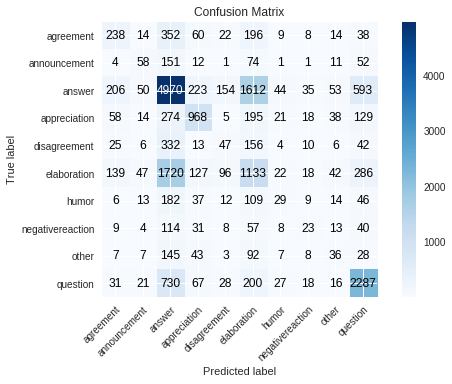

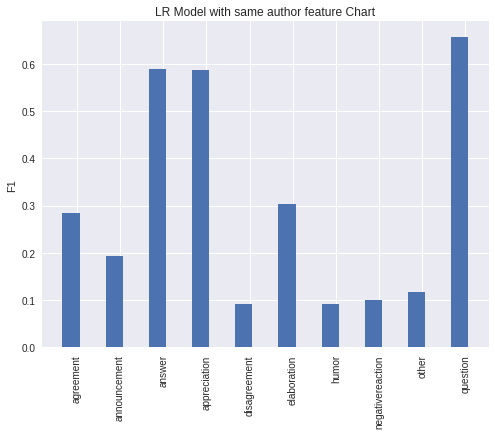

In [ ]:
totalcomments_train_tfidf = totalcomments_pipeline.fit_transform(data_train_posts)                       # x_train
totalcomments_test_tfidf = totalcomments_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
totalcomments_lr_tfidf_model = lr.fit(totalcomments_train_tfidf, train_labels)

evaluation_summary("LR Baseline with total comments feature", totalcomments_lr_tfidf_model.predict(totalcomments_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, totalcomments_lr_tfidf_model.predict(totalcomments_test_tfidf), totalcomments_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with total comments feature Chart', totalcomments_lr_tfidf_model, totalcomments_lr_tfidf_model.predict(totalcomments_test_tfidf), test_labels)

### Community
○ The subreddit the post came from

In [ ]:
community_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_keeppunct, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
        
      #Subreddit  
      ('subreddit', Pipeline([
        ('selector', ItemSelector(key='subreddit')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),
    
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with content+punctuation feature
Classifier 'LR Baseline with content+punctuation feature' has Acc=0.500 P=0.286 R=0.329 F1=0.299
                  precision    recall  f1-score   support

       agreement      0.246     0.340     0.285       689
    announcement      0.126     0.183     0.149       251
          answer      0.651     0.551     0.597      9388
    appreciation      0.581     0.628     0.604      1592
    disagreement      0.080     0.150     0.104       339
     elaboration      0.287     0.303     0.295      3436
           humor      0.057     0.158     0.084       165
negativereaction      0.075     0.167     0.103       138
           other      0.093     0.182     0.123       192
        question      0.667     0.631     0.648      3622

       micro avg      0.500     0.500     0.500     19812
       macro avg      0.286     0.329     0.299     19812
    weighted avg      0.540     0.500     0.517     19812


Confusion matrix:
 [[ 234 

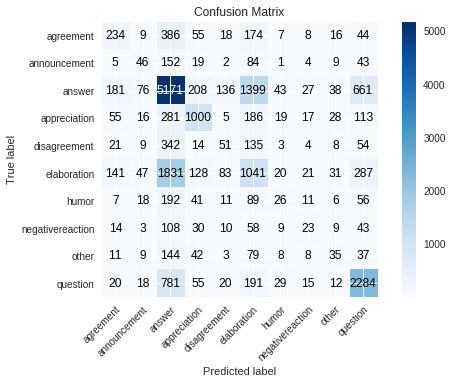

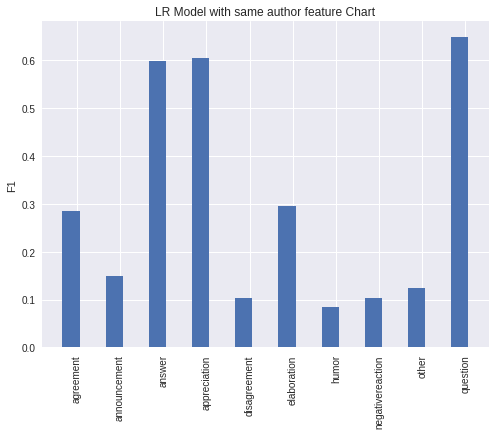

In [ ]:
community_train_tfidf = community_pipeline.fit_transform(data_train_posts)                       # x_train
community_test_tfidf = community_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
community_lr_tfidf_model = lr.fit(community_train_tfidf, train_labels)

evaluation_summary("LR Baseline with community feature", community_lr_tfidf_model.predict(community_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, community_lr_tfidf_model.predict(community_test_tfidf), community_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with community feature Chart', community_lr_tfidf_model, community_lr_tfidf_model.predict(community_test_tfidf), test_labels)

### Combined

Now finally it is time to combine all the features into one pipeline and see what the results are:

In [ ]:
combined_pipeline = Pipeline([
  ('union', FeatureUnion(
    transformer_list=[

      ('body', Pipeline([
        ('selector', ItemSelector(key='body')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize_keeppunct, binary=False, max_features=5000, ngram_range=(1,2), sublinear_tf=False)), 
        ])),

      ('author', Pipeline([
        ('selector', ItemSelector(key='author')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      ('title', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      #Metadata 
      ('sub_self', Pipeline([
        ('selector', ItemSelector(key='sub_self')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),

      #Structure  
      ('body_length', Pipeline([
        ('selector', ItemSelector(key='body_length')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),        

      #Author  
      ('same_auth', Pipeline([
        ('selector', ItemSelector(key='same_auth')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),        

      #Total Comments  
      ('total_comments', Pipeline([
        ('selector', ItemSelector(key='total_comments')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),        

      #Subreddit  
      ('subreddit', Pipeline([
        ('selector', ItemSelector(key='subreddit')),
        ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, binary=False,max_features=None, ngram_range=(1,1), sublinear_tf=True)), 
        ])),        
        
  ])
  ),
  ])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: LR Baseline with combined features
Classifier 'LR Baseline with combined features' has Acc=0.533 P=0.333 R=0.372 F1=0.343
                  precision    recall  f1-score   support

       agreement      0.249     0.333     0.285       711
    announcement      0.449     0.432     0.440       380
          answer      0.676     0.593     0.631      9056
    appreciation      0.593     0.627     0.609      1628
    disagreement      0.089     0.172     0.117       332
     elaboration      0.311     0.310     0.311      3643
           humor      0.066     0.175     0.096       171
negativereaction      0.065     0.185     0.096       108
           other      0.101     0.196     0.133       194
        question      0.728     0.694     0.711      3589

       micro avg      0.533     0.533     0.533     19812
       macro avg      0.333     0.372     0.343     19812
    weighted avg      0.568     0.533     0.548     19812


Confusion matrix:
 [[ 237    7  372   64   21 

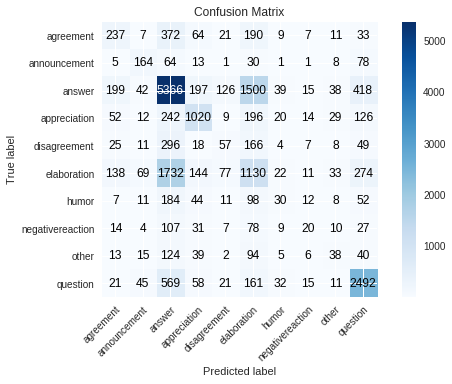

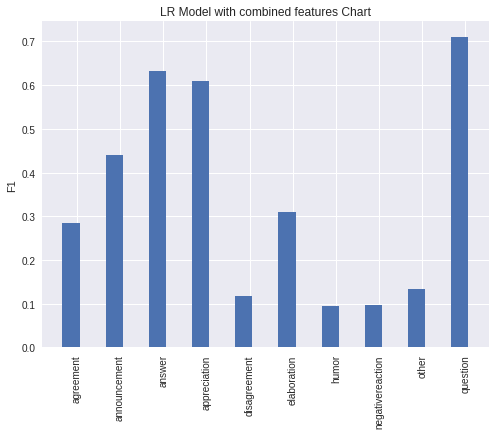

In [ ]:
combined_train_tfidf = combined_pipeline.fit_transform(data_train_posts)                       # x_train
combined_test_tfidf = combined_pipeline.transform(data_test_posts)

lr = LogisticRegression(C=10000, solver = 'saga', multi_class = 'auto')
combined_lr_tfidf_model = lr.fit(combined_train_tfidf, train_labels)

evaluation_summary("LR Baseline with combined features", combined_lr_tfidf_model.predict(combined_test_tfidf), test_labels)  

plot_confusion_matrix(test_labels, combined_lr_tfidf_model.predict(combined_test_tfidf), combined_lr_tfidf_model.classes_, title= 'Confusion Matrix')
create_plot('LR Model with combined features Chart', combined_lr_tfidf_model, combined_lr_tfidf_model.predict(combined_test_tfidf), test_labels)